# how to generate a random maze

This notebook explains an algorithm generating a maze with paths.
The irregular paths makes challenging to navigate the maze with a controllable avatar.
This kind of mazes are usaful for some research projects studying input and output for remote vehicle control.

## what kind of maze?

These are the requirements of a maze that the algorithm targets.
- single path
- irregular path widths
- the width of the path should be larger than a certain threshold
- enterance and exit exists

## the big picture

The algorithm creates irregular paths with two parts.
1. create coarse paths with straight walls.
2. make the walls irregular by attaching small blocks to the walls.

The algorithm works represents mazes with matrices. `1` means walls and `0` means paths.

The followings ar the parameters.

In [30]:
num_coarse_cells_row = 10
num_coarse_cells_col = 10

# the percentage of coarse path cells in the maze
path_percentage = 0.3

# fine cells are the ones that creates rough wall surfaces.

# per coarse cell
# final matrix size = (num_coarse_cells_row * fine_cells_per_coarse_cell_row, num_coarse_cell_col * fine_cells_per_coarse_cell_col)
num_fine_cells_row = 10
num_fine_cells_col = 10

# relative to fine cell size
min_path_width = 2

# how many iterations to attach small cells to the maze
max_wall_attach_steps = 2000

## create coarse path

The algorithm starts by creating coarse paths.

1. set entrance. entrance is on the edge of the matrix.
2. starting from the entrance, randomly choose adjacent cell that is not adjacent to path cell (`0`).
3. repeat step 2 until 1) hits the end of the matrix, which becomes the exit or 2) all adjacent cells are adjacent to path cells.
4. when the map is created, check the path percentage. If it is less than the threshold, repeat 2-3 again.

The reason why we are avoding path-adjacent cells is to not connect the path in the middle of the algorithm. Our goal is to make a single path.

In [31]:
import numpy as np
import random

def create_coarse_maze():
    coarse_maze = create_random_coarse_maze()
    cell_percentage = calculate_path_coverage(coarse_maze)
    count = 0
    while cell_percentage < path_percentage:
        coarse_maze = create_random_coarse_maze()
        cell_percentage = calculate_path_coverage(coarse_maze)
        count += 1

    print("Number of coarse maze generation attempts: ", count)

    return coarse_maze

def calculate_path_coverage(maze: np.ndarray) -> float:
    return np.mean(1 - maze)

def create_random_coarse_maze():
    coarse_maze = np.ones((num_coarse_cells_row, num_coarse_cells_col), dtype=np.uint8)
    
    # always the left top cell is the start
    entry_row = 1
    entry_col = 0
    coarse_maze[entry_row, entry_col] = 0
    cursor = (entry_row, entry_col)
    backtracking_stack = [cursor]

    # then there is only one possible step
    coarse_maze[entry_row, entry_col + 1] = 0
    cursor = (entry_row, entry_col + 1)

    # the backtrack point is used to avoid re-selecting the backtracked cells.
    backtrack_point = (-1, -1)

    ### CUROSOR DOES NOT POINT A CELL IN THE BACKTRACKING STACK
    while True:
        prev_cell = backtracking_stack[-1]
        # TODO: prevernt infinite loop
        next_cell = select_next_random_cell(
            coarse_maze, cursor[0], cursor[1], backtrack_point[0], backtrack_point[1]
        )

        # reset the backtrack point after using it to prevent infinite loop
        backtrack_point = (-1, -1)

        if next_cell is not None:
            coarse_maze[next_cell[0], next_cell[1]] = 0
            backtracking_stack.append(cursor)
            cursor = next_cell

            if is_on_the_map_boundary(coarse_maze, cursor[0], cursor[1]):
                # cursor is on the edge of the map
                # this will be the exit point
                break
        else:
            # DFS fail
            # backtrack

            if len(backtracking_stack) == 0:
                raise Exception("Failed to create a coarse maze. DFS fail.")

            backtrack_point = (cursor[0], cursor[1])
            coarse_maze[cursor[0], cursor[1]] = 1
            cursor = backtracking_stack.pop()

    return coarse_maze

def select_next_random_cell(
    maze: np.ndarray,
    current_row: int,
    current_col: int,
    exclude_row: int = -1,
    exclude_col: int = -1,
) -> tuple[int, int]:
    """Select a random cell that is not visited, not adjacent to the visited cells, and not at the boundary"""

    def is_cell_valid(row: int, col: int) -> bool:
        return (
            (row != exclude_row and col != exclude_col)
            and is_in_the_map(maze, row, col)
            and is_not_visited(maze, row, col)
            and is_not_adjacent_to_visited(maze, current_row, current_col, row, col)
        )

    valid_next_cells: list[(int, int)] = []
    candiates = [
        (current_row - 1, current_col),
        (current_row + 1, current_col),
        (current_row, current_col - 1),
        (current_row, current_col + 1),
    ]

    # check 4 adjacent cells
    for row, col in candiates:
        if is_cell_valid(row, col):
            valid_next_cells.append((row, col))

    if len(valid_next_cells) == 0:
        return None

    return random.choice(valid_next_cells)

def is_in_the_map(maze: np.ndarray, row: int, col: int) -> bool:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    return 0 <= row < n_maze_row and 0 <= col < n_maze_col

def is_on_the_map_boundary(maze: np.ndarray, row: int, col: int) -> bool:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    return 0 == row or row == n_maze_row - 1 or 0 == col or col == n_maze_col - 1

def is_not_visited(maze: np.ndarray, row: int, col: int) -> bool:
    return maze[row, col] == 1

def is_not_adjacent_to_visited(maze: np.ndarray, current_row: int, current_col: int, next_row: int, next_col: int) -> bool:
    if not is_in_the_map(maze, next_row, next_col):
        return False

    adjacent_cells_except_current = []
    for cell in [(next_row-1, next_col), (next_row+1, next_col), (next_row, next_col+1), (next_row, next_col-1)]:
        if not is_in_the_map(maze, cell[0], cell[1]):
            continue

        if cell != (current_row, current_col):
            adjacent_cells_except_current.append(cell)

    for cell in adjacent_cells_except_current:
        if (maze[cell[0], cell[1]] == 0):
            return False

    return True

Number of coarse maze generation attempts:  170


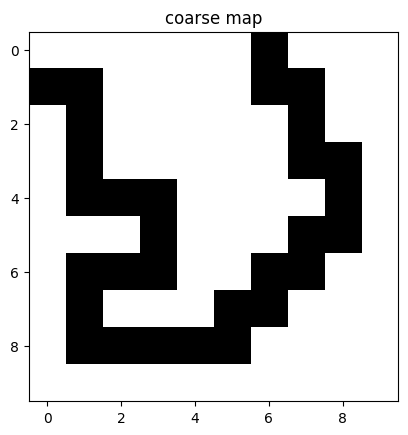

In [33]:
import numpy as np
from matplotlib import pyplot as plt

coarse_maze = create_coarse_maze()

plt.title("coarse map")
plt.imshow(coarse_maze, cmap='gray')


## create fine cells

Make the matrix larger (or finer) so that we can add small blocks to the wall.
Do this by doing Kronecker multiplicaiton.

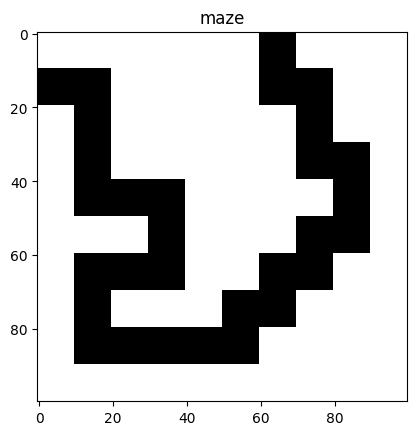

In [34]:
sub_cell = np.ones((num_fine_cells_row, num_fine_cells_col), dtype=np.uint8)

# Kronecker multiplication
maze = np.kron(coarse_maze, sub_cell)
plt.title("maze")
plt.imshow(maze, cmap='gray')

## make the walls irregular by adding small blocks

It is kind of tricky to add small blocks on the walls because the algorithm should not make the path smaller than the `avatar_size`.
Therefore, the algorithm measures distance between the walls after adding a small block. More precisely, the algorithm should measure the distance between the added block and the closest distance to the other wall, which is on the opposite side. And check if the distance is larger than `avatar_size`. If not, then the algorithm revert adding the block.

To measure the distance between a point and the other wall, we have to check what are the points on the same wall and what are on the other wall.
The algorithm finds *connected components* in the maze. Since there are only a single path, there should be two components in the maze (3 including the path).

When finding connected components, using `ndimage.label` is convenient. However, it considers cross-connected cells as *connected*. However, the algorithm up to now can create walls that are connected diagonally. 

Here is an example.

In [35]:
example = np.array([[1, 0], [0, 1]])
example = np.kron(example, np.ones((2, 2)))
print(example)

[[1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]]


Therefore, the algorithm should cross-connect the diagonal-connected components.

### cross-connect the components

This is similar to `dilate` in image processing.
Run convolution with diagonal kernal and threshold it.

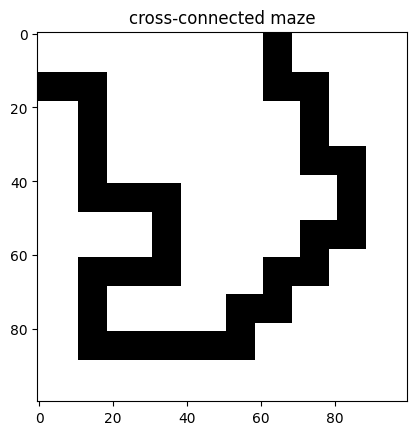

In [36]:
from scipy import ndimage

kernal = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])
cross_connected_maze = ndimage.convolve(maze, kernal, mode='constant', cval=0)
cross_connected_maze[cross_connected_maze > 0] = 1

plt.title("cross-connected maze")
plt.imshow(cross_connected_maze, cmap='gray')


### label the components

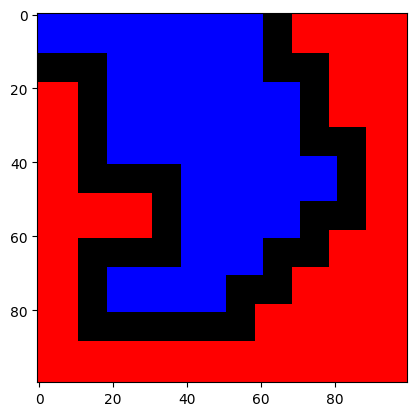

In [37]:
from matplotlib.colors import ListedColormap

labeled_maze, num_features = ndimage.label(cross_connected_maze)

cmap = ListedColormap(['black', 'blue', 'red'])
plt.imshow(labeled_maze, cmap)

### split compoenents

Split the maze into two. Each maze only has each one wall component cells.

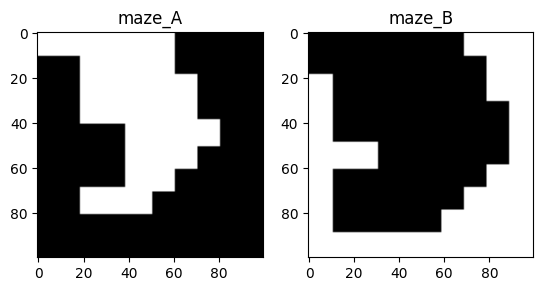

In [51]:
def split_components(maze:np.ndarray, labeled_maze: np.ndarray) -> (np.ndarray, np.ndarray):
    # ensure paths are 0 and the other compoents are >0
    binary_maze = maze * (labeled_maze + 1)
    labels = np.unique(binary_maze)
    label_A = np.median(labels)
    label_B = np.max(labels)

    maze_A = np.zeros_like(binary_maze)
    maze_A[binary_maze == label_A] = 1
    maze_B = np.zeros_like(binary_maze)
    maze_B[binary_maze == label_B] = 1

    return (maze_A, maze_B)

maze_A, maze_B = split_components(cross_connected_maze, labeled_maze)

fig, axs = plt.subplots(1, 2)
axs[0].set_title('maze_A')
axs[1].set_title('maze_B')
axs[0].imshow(maze_A, cmap='gray')
axs[1].imshow(maze_B, cmap='gray')


## iteration: select boundary points and measure distances

This is the step where actually attaches cells to the wall.

1. randomly select the wall
2. randomly select a point on the wall
3. fill point as the wall, if the minimum distance between the point and the other wall is larger then `avatar_size`.
4. repeat `max_wall_attach_steps` steps.

### select boundary points on the walls

Text(0.5, 1.0, 'Boundary points of maze A')

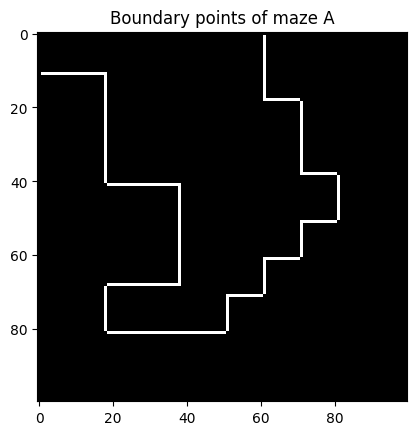

In [52]:
def select_near_boundary_points(maze: np.ndarray) -> list[(int, int)]:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]

    cross_kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    kernel_sum = np.sum(cross_kernel)

    conved_maze = ndimage.convolve(maze, cross_kernel, mode='constant', cval=1)

    boundary_points = np.argwhere((conved_maze < kernel_sum) & (conved_maze > 0))

    # exclude the map boundary
    boundary_points = filter(lambda x: not is_on_the_map_boundary(maze, x[0], x[1]), boundary_points)
    # exclude the walls
    boundary_points = filter(lambda x: maze[x[0], x[1]] == 0, boundary_points)
    
    return list(boundary_points)

near_boundary_points_A = select_near_boundary_points(maze_A)
empty_maze = np.zeros_like(maze_A)

for point in near_boundary_points_A:
    empty_maze[point[0], point[1]] = 1

plt.imshow(empty_maze, cmap='gray')
plt.title('Boundary points of maze A')

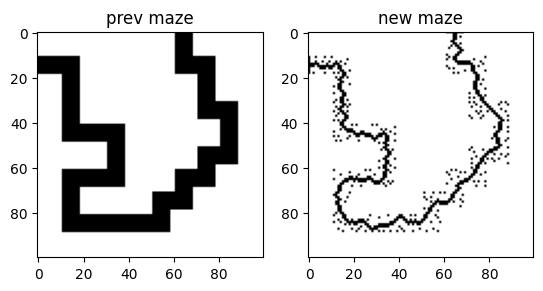

In [59]:
def select_random_boundary_point(component_maze: np.ndarray) -> (int, int):
    near_boundary_points = select_near_boundary_points(component_maze)
    return random.choice(near_boundary_points)

def calculate_min_dist_to_point(maze: np.ndarray, row: int, col: int) -> int:
    near_boundary_points = select_near_boundary_points(maze)
    distances = [abs(row - point[0]) + abs(col - point[1]) for point in near_boundary_points]
    return min(distances)


def add_random_wall_point(maze_A: np.ndarray, maze_B: np.ndarray, min_path_width: float) -> (np.ndarray, np.ndarray):
    maze_to_add_point = random.choice([maze_A, maze_B])
    add_point_to_maze_A = maze_to_add_point is maze_A
    other_maze = maze_A if maze_to_add_point is maze_B else maze_B
    
    random_near_boudary_point = select_random_boundary_point(maze_to_add_point)

    min_dist_to_point = calculate_min_dist_to_point(other_maze, random_near_boudary_point[0], random_near_boudary_point[1])
    
    if min_dist_to_point < min_path_width:
        return (maze_A, maze_B)

    copied_maze_A = maze_A.copy()
    copied_maze_B = maze_B.copy()
    if add_point_to_maze_A:
        copied_maze_A[random_near_boudary_point[0], random_near_boudary_point[1]] = 1
    else:
        copied_maze_B[random_near_boudary_point[0], random_near_boudary_point[1]] = 1

    return copied_maze_A, copied_maze_B


iter_count = 0
while iter_count < max_wall_attach_steps:
    maze_A, maze_B = add_random_wall_point(maze_A, maze_B, min_path_width=min_path_width)
    iter_count += 1

new_maze = maze_A + maze_B

fig, axs = plt.subplots(1, 2)
axs[0].set_title('prev maze')
axs[1].set_title('new maze')
axs[0].imshow(cross_connected_maze, cmap='gray')
axs[1].imshow(new_maze, cmap='gray')


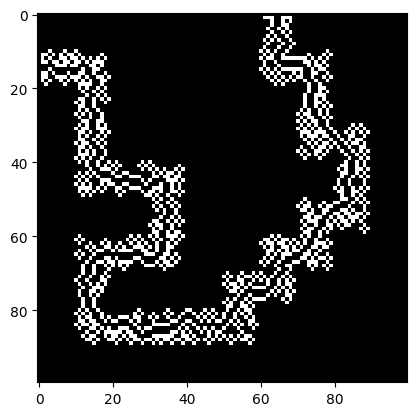

In [61]:
negative_maze = np.ones_like(new_maze) - new_maze
near_boundary_points = select_near_boundary_points(negative_maze)

sparse_maze = np.zeros_like(maze)
for point in near_boundary_points:
    sparse_maze[point[0], point[1]] = 1

plt.imshow(sparse_maze, cmap='gray')